In [ ]:
import sys
!"{sys.executable}" -m pip install scipy ipywidgets
import scipy_material

<h1 align='center'>Statistical tests with the Pingouin and SciPy libraries</h1>

<div style='text-align:center'><img width=600 src='https://pingouin-stats.org/build/html/_images/logo_pingouin.png' /></div>
<div style='text-align:center'><img width=300 src='https://docs.scipy.org/doc/scipy/_static/logo.svg' /></div>

The [Pingouin](https://pingouin-stats.org/build/html/index.html) library features a selection of commonly-used statistical operations. The provided functions have verbose output and can be used independently of one another.

In [2]:
import pingouin as pg

In contrast, [SciPy](https://docs.scipy.org/doc/scipy/reference/#api-definition) is a collection of mathematical tools aiming at diverse fields. It is the one of the oldest Python libraries. Its functionalities are split in several modules:

In [3]:
from scipy import (
    cluster,     # Clustering algorithms
    constants,   # Physical and mathematical constants
    fftpack,     # Fast Fourier Transform routines
    integrate,   # Integration and ordinary differential equation solvers
    interpolate, # Interpolation and smoothing splines
    io,          # Input and Output
    linalg,      # Linear algebra
    ndimage,     # N-dimensional image processing
    odr,         # Orthogonal distance regression
    optimize,    # Optimization and root-finding routines
    signal,      # Signal processing
    sparse,      # Sparse matrices and associated routines
    spatial,     # Spatial data structures and algorithms
    special,     # Special functions
    stats,       # Statistical distributions and functions
)

We will make a brief overview of the `scipy.stats` module only, in particular basic functionalities that cannot be found in Pingouin.

# Outline

Descriptive statistics are well covered by Pandas and the plotting libraries.
This course focuses merely on statistical tests.

* Distributions
* Student $t$ tests
    * compare a sample mean against the population mean
    * compare means of two independent samples
    * compare the means of paired samples
* Analyses of variance
    * compare more than two group means
* Tests for other tests' assumptions
    * normality tests
    * homoscedasticity tests
* $\chi^2$ tests for categorical variables
    * homogeneity and independence tests
    * goodness-of-fit tests
* Effect sizes

# Distributions

For this section, the related utilities are provided by `scipy.stats`:

In [4]:
import numpy as np
from scipy import stats

Reminder about module loading:

Example: how to access the `sem` function defined in the `scipy.stats` module?

In [5]:
%%script echo skipping

import scipy.stats
scipy.stats.sem

from scipy import stats
stats.sem

from scipy.stats import *
sem

skipping


## Confidence intervals

Common information such as the sample mean or standard deviation are trivial to obtain. For example, we have seen Pandas' `describe`:

In [6]:
dataframe = pg.read_dataset('tips')
dataframe.describe()
#dataframe.describe(exclude=np.number)

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


To report the value of the population mean and account for the uncertainty that results from the fact the true value is actually unknown (the sample mean above is our best guess), we can give a confidence interval instead.

Reminder: the population mean follows a normal distribution centered at the sample mean, with standard deviation equal to the standard error of the mean (or, equivalently, the standard deviation of the sample divided by the square root of the sample size).

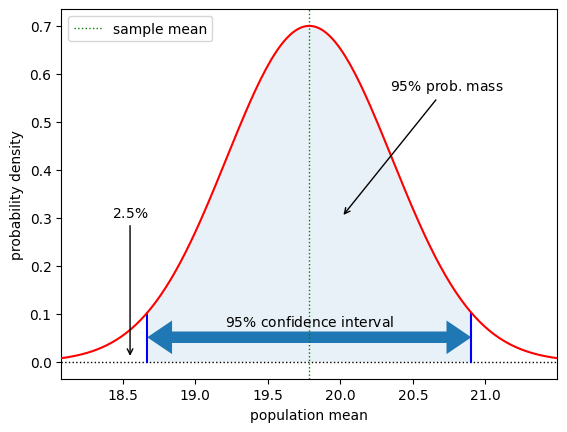

In [7]:
scipy_material.illustration_confidence_interval(19.785943, stats.sem(dataframe['total_bill']))

Computing a confidence interval with SciPy involves instantiating the normal distribution with the `norm` function and calling the `interval` method of the returned object.

In [8]:
X = dataframe['total_bill']
mu = np.mean(X)
sigma = stats.sem(X)
distribution_of_the_mean = stats.norm(mu, sigma)

In [9]:
distribution_of_the_mean.interval(0.95)

(18.668922839262997, 20.902962406638643)

Note again that we have set the scale parameter `sigma` equal to the sem. In contrast, if variable `total_bill` followed a normal distribution, we could define its distribution as:

In [10]:
normal_distribution = stats.norm(X.mean(), X.std())

The objects `norm` returns (*e.g.* `distribution_of_the_mean`) feature numerous other methods:

In [11]:
# probability density function
distribution_of_the_mean.pdf(19.0)

0.2704798697499871

In [12]:
# cumulative distribution function
distribution_of_the_mean.cdf(19.0)

0.0839406210836206

See [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) for more methods.

As another example, we can make use of the inverse survival function `isf` to re-implement the calculation of the $1-\alpha=95\%$ confidence interval based on the following formula:

$$
\bar{x} \pm z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}
$$

Indeed, $z_{1-\alpha/2}$ is calculated as follows:

In [13]:
alpha = 0.05
z = stats.norm().isf(alpha / 2)
z

1.9599639845400545

For a $95\%$ confidence interval, we usually take $z\approx 1.96$. Note we took the standard normal distribution, with null mean and unit standard deviation (`stats.norm()` is equivalent to `stats.norm(0, 1)`).

$\frac{\sigma}{\sqrt{n}}$ is the standard deviation of the sample mean, or standard error of mean, that we have already calculated using the `sem` function.

In [14]:
print(f'Bills are {mu:.2f} ± {z * sigma:.2f} on average')

Bills are 19.79 ± 1.12 on average


## Fitting

We have seen how to fit a normal distribution explicitly passing a mean and standard deviation. More generally, for any distribution from `scipy.stats`, we can get the required parameters using the `stats.<distribution>.fit` method. For example, for distribution `stats.norm` with sample `X`:

In [15]:
normal_distribution = stats.norm(*stats.norm.fit(X))

Now, unlike the population mean, there is no guarantee a sample follows a normal distribution.

To determine what distribution a sample best follows, we can fit various distributions to the data and visually appreciate how well these distributions match with the data by plotting a scaled histogram and the probability density functions of the fitted distributions on top of the histogram.

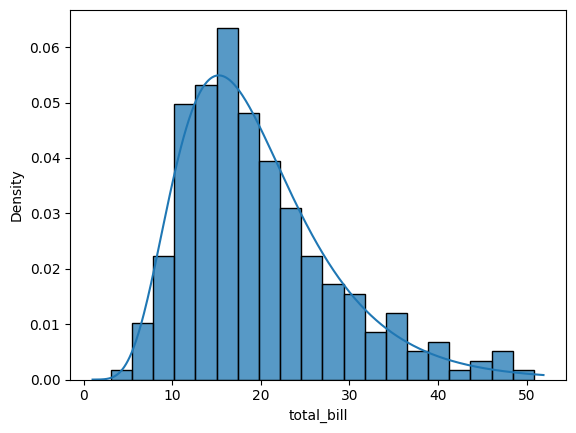

In [16]:
# plot the histogram
import seaborn as sns
sns.histplot(X, bins=20, stat='density')

# fit a log-normal distribution
lognorm = stats.lognorm(*stats.lognorm.fit(X))

# draw the probability density function
from matplotlib import pyplot as plt
grid = np.arange(1, 52, .1)
plt.plot(grid, lognorm.pdf(grid));

# fit and overlay more distributions
#weibull = stats.weibull_min(*stats.weibull_min.fit(X))
#plt.plot(grid, weibull.pdf(grid));
#t = stats.t(*stats.t.fit(X))
#plt.plot(grid, t.pdf(grid));
#chi2 = stats.chi2(*stats.chi2.fit(X))
#plt.plot(grid, chi2.pdf(grid));

Note that plotting histograms is good practice anyway, because it helps to spot data distributions with multiple modes. Multiple modes in a sample are a red flag for tests that compare estimates of central tendency (*e.g.* means).

...and we can test whether `total_bill` follows a log-normal distribution in our sample with the one-sample Kolmogorov-Smirnov test:

In [17]:
statistic, pvalue = stats.kstest(X, lognorm.cdf)
pvalue

0.7387575212859724

# Statistical testing


> What have we just done?

We compared our **observations** `x` with some **expectation**.

We actually formulated a so-called *null hypothesis*, denoted $H_0$, that models the situation such that "nothing is going on", *i.e.* the observations meet the expectation.

We also implicitly defined an alternative hypothesis, usually denoted $H_1$ or $H_A$, that can simply be the opposite of $H_0$.

For example:

$$
\left\{
\begin{array}{ l l l }
H_0: & X \sim \mathcal{N}(\mu, \sigma^2) & \mbox{with } \mu \mbox{ assumed to be } \bar{x} \mbox{ and } \sigma^2 \mbox{ as } \frac{1}{n-1}\sum_{i=0}^{n-1} (x_i - \bar{x})^2 \\
H_A: & \mbox{not } H_0
\end{array}
\right.
$$

A test consists in contrasting the two incompatible hypotheses.

If we had a single observation – say $z=1.4$ – to compare with a distribution – say $\mathcal{N}(0,1)$ – we would simply compute the probability for this value to be drawn from this distribution (or not):

In [18]:
z = 1.4

N = stats.norm(0, 1)

onesided_pvalue = N.sf(z) # sf= survival function
twosided_pvalue = 2 * min(N.cdf(z), N.sf(z))

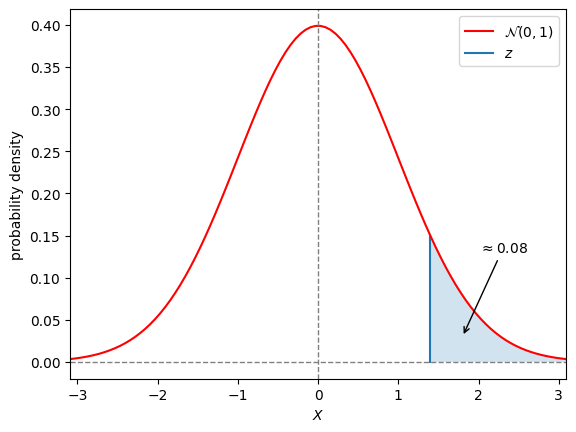

In [19]:
scipy_material.illustration_onesided_probabilitymass(z, N, onesided_pvalue)

In practice, all tests boil down to comparing a single value with a reference distribution. Basically, a test expresses the discrepancy between the observations and the expectation in the shape of a *statistic*, and this statistic is supposed to follow a given distribution under $H_0$.

This is used as a basis to calculate a *p*-value that estimates the probability of erroneously rejecting $H_0$.

The experimenter also defines a significance level $\alpha$, with common values $\alpha=0.05$ or $0.01$, that sets the maximum tolerated risk of making a *type-1 error*, *i.e.* of rejecting $H_0$ by chance.
If the obtained <em>p</em>-value is lower than $\alpha$, then s·he can conclude there is sufficient evidence to reject $H_0$.

In [20]:
%%html
<style>table#typeoferrors { text-align: center; font-size: large; margin-left: 1px;} #typeoferrors td { text-align: center; font-size: large; border-right: solid 1px black; border-bottom: solid 1px black; } #typeoferrors td.border { font-size: small; border-left: solid 1px black; border-top: solid 1px black; } #typeoferrors td.wrong { color: orange; } #typeoferrors td.ok { color: green; } #typeoferrors span.sub { font-size: x-small; } #typeoferrors td.footnote { text-align: left; font-size: xx-small; border-right: 0px; border-bottom: 0px; } </style> <table id="typeoferrors">     <tr><td rowspan="2" colspan="2"></td><td colspan="2" class="border">Conclusion about $H_0$<br />from the statistical test</td></tr>    <tr><td>accept</td><td>reject</td></tr>     <tr><td rowspan="2" class="border">Truth about $H_0$<br />in the population</td><td>true</td><td class="ok">Correct</td><td  class="wrong">Type 1 error<br /><span class="sub">observe difference<br />when none exists</span></td></tr>     <tr><td>false</td><td class="wrong">Type 2 error<br /><span class="sub">fail to observe difference<br />when one exists</span></td><td class="ok">Correct</td></tr>     <tr><td colspan="4" class="footnote"> <a href="https://faculty.nps.edu/rbassett/_book/hypothesis-testing-one-sample.html#fig:errorsHypTesting">https://faculty.nps.edu/rbassett/_book/hypothesis-testing-one-sample.html#fig:errorsHypTesting</a>     </td></tr> </table>

## *t* tests

*t* tests derive a statistic that is supposed to follow the [Student's *t* distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) under $H_0$:

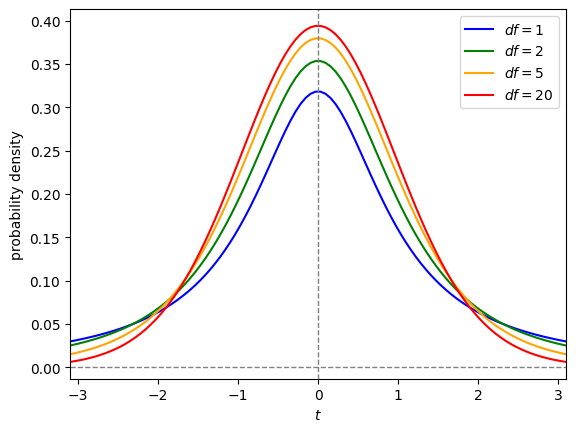

In [21]:
scipy_material.illustration_t_pdfs()

At high degrees of freedom, the *t* distribution approaches the normal distribution. At lower degrees of freedom, the *t* distribution exhibits heavier tails and is less sensitive to extreme values.

There exist several *t* tests. Pingouin's [`ttest`](https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest) function provides several of them:

`pg.ttest(x, y, paired=False, alternative='two-sided', correction='auto', r=0.707, confidence=0.95)`

### One-sample *t* test

This test compares a sample's central tendency (*sample mean*) with a reference value (*population mean*).

<table style="text-align: center;"><tr><td>
<img src='../images/8mice.svg' />
</td><td>
<img src='../images/Scientific_journal_icon.svg' width="96px" />
</td></tr><tr><td><center>
<code>x=[49.5 81.9 64.0 17.3 59.8 94.6 69.9 12.4]</code>
</center></td><td><center>
<code>&mu;=50</code>
</center></td></tr></table>

Let us call $\mu$ this reference value. Our expectation is that the sample mean $\bar{X}$ is close enough to $\mu$.
In other words, $H_0: \bar{X} = \mu$.
The statistic is:
$$
\frac{\bar{X} - \mu}{\mathrm{SEM}} \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \sim t(n-1) \mbox{ } \textrm{under} \mbox{ } H_0
$$

In [22]:
x = np.array([49.47257879, 81.93967205, 64.030398, 17.25423608, 59.80082512,
              94.56012514, 69.91672899, 12.39640637])

mu = 50

With Pingouin:

In [23]:
pg.ttest(x, mu)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.602406,7,two-sided,0.565899,"[31.95, 80.4]",0.212983,0.391,0.08203


For completeness, SciPy's one-sample *t* test is [ttest_1samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html):

`scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided')`

In [24]:
stats.ttest_1samp(x, mu)

TtestResult(statistic=0.6024056396957578, pvalue=0.5658990587680466, df=7)

### *t* test for independent samples

This test compares the means of two samples or groups, *e.g.* a control sample and a sample from a mutated population: $H_0: \bar{X_1} = \bar{X_2}$.

<table style="text-align:center;"><tr><td>
<img src="../images/8mice.svg" alt="sample of the control population" />
</td><td>
<img src="../images/8mutants1.svg" alt="sample of a mutated population" />
</td></tr><tr><td><center>
<code>x<sub>1</sub>=[49.5 81.9 64.0 17.3 59.8 94.6 69.9 12.4]</code>
</center></td><td><center>
<code>x<sub>2</sub>=[64.2 96.6 101.9 85.3 66.5 63.9 127.6 55.0]</code>
</center></td></tr></table>

In [25]:
x1 = x
x2 = np.array([64.22723692, 96.56483856, 101.94191774, 85.31918879,
               66.4952999, 63.88841224, 127.63861749, 55.00527005])

With Pingouin:

In [26]:
pg.ttest(x1, x2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.961743,14,two-sided,0.069989,"[-55.4, 2.47]",0.980872,1.42,0.447175


SciPy's *t* test for independent samples uses the statistic $t=\frac{\bar{X_1}-\bar{X_2}}{\sqrt{(\frac{1}{n_1}+\frac{1}{n_2})\mbox{ }\textrm{PooledVariance}}}$ with $\textrm{PooledVariance} = \frac{1}{n_1+n_2-2}\sum_{j\in\{1,2\}}\sum_i (x_{ij}-\bar{x_j})^2$ and is available as [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html):

`scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)`

In [27]:
stats.ttest_ind(x1, x2)

TtestResult(statistic=-1.96174329619957, pvalue=0.06998888828308221, df=14.0)

Results are consistent.

However, if the two samples were of different sizes, Pingouin's `ttest` would automatically use Welch's *t* test instead.

SciPy's `ttest_ind` also provides this variant of the *t* test, passing argument `equal_variance=False`. It also provides a less common variant known as Yuen's *t* test, with `equal_var=False` and `trim=0.2` (requires more data).

Note that SciPy's default *t* test does not require equal numbers of observations per group. However, it assumes the groups are normally distributed (but is relatively robust to non-«extreme non-normality») and, more importantly, have [similar variances ($0.5<\frac{s_{X_1}}{s_{X_2}}<2$)](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_similar_variances_(1/2_%3C_sX1/sX2_%3C_2)).

### *t* test for paired samples

<img src='../images/paired1.svg' />

Let us now assume `x1[i]` and `x2[i]` are measurements from a same animal `i`, under two different experimental conditions.

With Pingouin:

In [28]:
pg.ttest(x1, x2, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.361598,7,two-sided,0.050223,"[-52.96, 0.03]",0.980872,1.892,0.664343


SciPy's *t* test for paired samples is [ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html):

`scipy.stats.ttest_rel(a, b, axis=0, nan_policy='propagate', alternative='two-sided')`

This is actually a one-sample *t* test of the between-group differences against a population mean equal to zero (compare [1](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/stats.py#L6450-L6460) and [2](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/stats.py#L5647-L5656)).

### Effect sizes

Very low *p*-values are not measurements of the strength of an effect. One should consider the *effect size* instead.

A common measure of effect size for two independent samples is [Cohen's $d$](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d): $d = \frac{\bar{X_2}-\bar{X_1}}{\sqrt{\textrm{PooledVariance}}}$

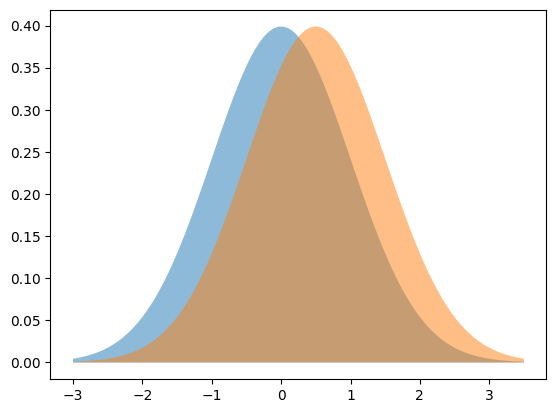

interactive(children=(FloatSlider(value=0.5, description='cohen_d', max=4.0), Output()), _dom_classes=('widget…

In [29]:
scipy_material.illustration_cohen_d();

With large enough sample sizes, one can find significant effects of size $0.1$ for example, which may not be of practical interest. Statistical significance does not imply practical significance.
   
Measurements of effect size were proposed together with [tables](https://core.ecu.edu/wuenschk/docs30/EffectSizeConventions.pdf) for interpreting size values. For example, for Cohen's $d$:
   
| $|d|$ | size of effect |
| :-: | :-- |
| $0.2$ | small |
| $0.5$ | medium |
| $0.8$ | large |

Pingouin's [compute_effsize](https://pingouin-stats.org/build/html/generated/pingouin.compute_effsize.html#pingouin.compute_effsize) provides various effect sizes (default is Cohen's *d*) for the comparison of two means, for dependent or independent (default) samples:

In [30]:
pg.compute_effsize(x1, x2)

-0.980871648099785

## Analysis of variance

### One-way ANOVA

Comparing three or more group means reads $H_0: \bar{X_0} = \bar{X_1} = ... = \bar{X_k}$ and is usually carried out with an *analysis of variance*.

The total variance ($SS_{\textrm{total}}$) is decomposed as the sum of two terms: *within-group* variance ($SS_{\textrm{error}}$) and *between-group* variance ($SS_{\textrm{treatment}}$).

$$
\underbrace{\sum_j\sum_i (x_{ij} - \bar{\bar{x}})^2}_{SS_{\textrm{total}}} = \underbrace{\sum_j\sum_i (\bar{x_j} - \bar{\bar{x}})^2}_{SS_{\textrm{treatment}}} + \underbrace{\sum_j\sum_i (x_{ij} - \bar{x_j})^2}_{SS_{\textrm{error}}}
$$
Many statistical tools give the following detailed table:

| Source | Degrees of<br />freedom | Sum of squares | Mean squares | $\mbox{ }F\mbox{ }$ | $p$-value |
| :- | :-: | :-: | :-: | :-: | :-: |
| Treatment | $k-1$ | $SS_{\textrm{treatment}}$ | $MS_{\textrm{treatment}}$ | $\frac{MS_{\textrm{treatment}}}{MS_{\textrm{error}}}$ | $\mbox{ }p\mbox{ }$ |
| Error | $N-k$ | $SS_{\textrm{error}}$ | $MS_{\textrm{error}}$ | | |
| Total | $N-1$ | $SS_{\textrm{total}}$ | | | |

The statistic $F = \frac{MS_{\textrm{treatment}}}{MS_{\textrm{error}}}$ follows the Fisher's [F](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html) distribution under $H_0$.

More about it at: https://www.coursera.org/learn/stanford-statistics/lecture/pskeN/the-idea-of-analysis-of-variance

If we define three samples or groups:

In [31]:
# copied-pasted from https://www.statology.org/bartletts-test-python/
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

To perform an ANOVA with Pingouin, we will have to represent the above data in a single DataFrame, in the so-called *long format*, with one row = one observation, and each variable (both dependent and independent) as a column:

In [32]:
import pandas as pd

df = pd.DataFrame(dict(
    response = np.concatenate([A,B,C]),
    group    = np.repeat(['A','B','C'], [len(A),len(B),len(C)]),
))

df.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
response,85,86,88,75,78,94,98,79,71,80,...,79,78,88,94,92,85,83,85,82,81
group,A,A,A,A,A,A,A,A,A,A,...,C,C,C,C,C,C,C,C,C,C


With Pingouin:

In [33]:
pg.anova(df, dv='response', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,2.357532,0.113848,0.14867


SciPy also provides a [one-way ANOVA](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/mstats_basic.py#L2937-L2967) with function [f_oneway](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.f_oneway.html):

In [34]:
stats.f_oneway(A, B, C)

F_onewayResult(statistic=2.3575322551335636, pvalue=0.11384795345837218)

The ANOVA is an *omnibus* test and does not tell which groups exhibit differing means. Specific differences are later identified using *post-hoc tests* (more about it in next session).

### Size effect

Pingouin's `anova` provides the partial $\eta_p^2=\frac{SS_{\textrm{treatment}}}{SS_{\textrm{treatment}}+SS_{\textrm{error}}}$ in the returned table.

You can pass argument `effsize='n2'` to get the $\eta^2=\frac{SS_{\textrm{treatment}}}{SS_{\textrm{error}}}$ instead.

### Multi-way ANOVA

Pingouin's [`anova`](https://pingouin-stats.org/build/html/generated/pingouin.anova.html#pingouin.anova) can take a __list__ of factors as argument `between`. Beware that it treats the designated columns as categorical variables and does not warn if the data are continuous. Pay attention to the reported numbers of degrees of freedom.

In [35]:
plant_data = pd.DataFrame({
    'water':  np.repeat(['daily', 'weekly'], 15),
    'sun':    np.tile(np.repeat(['low', 'med', 'high'], 5), 2),
    'height': np.array([
                        6.3, 6.8, 5.5, 5.1, 6.0, 6.1, 5.0, 6.1, 3.6, 5.4,
                        6.4, 5.7, 8.3, 7.7, 7.0, 2.9, 3.2, 2.3, 3.9, 4.1,
                        3.5, 5.3, 5.8, 4.6, 3.6, 5.2, 6.2, 5.1, 6.7, 7.0,
])})

In [36]:
pg.anova(plant_data, dv='height', between=['water', 'sun'])

,Source,SS,DF,MS,F,p-unc,np2
0,water,15.552000,1,15.552000,19.117394,0.000205,0.443380
1,sun,21.424667,2,10.712333,13.168203,0.000138,0.523208
2,water * sun,5.694000,2,2.847000,3.499693,0.046376,0.225791
3,Residual,19.524000,24,0.813500,NaN,NaN,NaN


Note that Pingouin's `anova` defaults to using type-2 sums of squares. Matlab `anovan` function uses type-3 ss instead.

In the above table, we observe an interaction effect between the two factors. If we plot the data, we should the effect of *e.g.* `water` depends on the other factor `sun`:

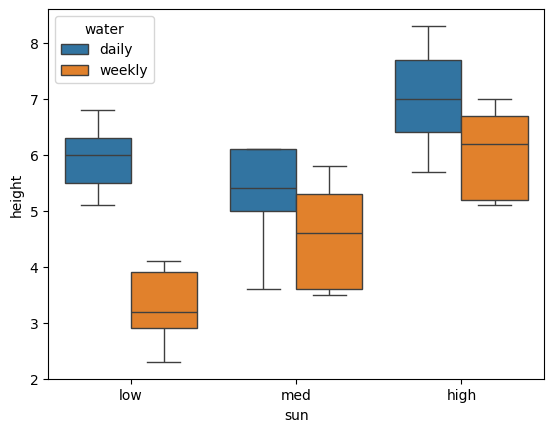

In [37]:
sns.boxplot(data=plant_data, x='sun', y='height', hue='water');

Alternatively, Pingouin provides an interaction plot:

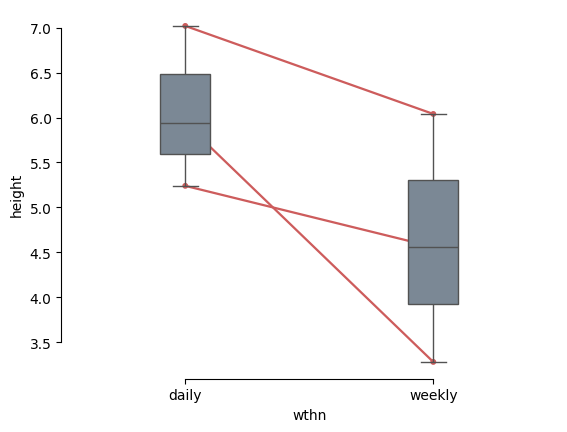

In [38]:
pd.set_option('future.no_silent_downcasting', True) # hide a warning message that the next expression would generate as of pandas 2.2.2 and pingouin 0.5.4
pg.plot_paired(data=plant_data, dv='height', within='water', subject='sun');

### Assumptions

The standard *F* test requires the data to exhibit the following properties:

* independent observations,
* normally distributed residuals,
* all groups have equal population variance (*homoscedasticity*),
* at least 5 observations ($n \ge 5$) per group (and equal number).

Pingouin provides [more forms of analyses of (co-)variance](https://pingouin-stats.org/build/html/api.html#anova-and-t-test).

## Checking for common assumptions

Most parametric tests make assumptions or have requirements on the distribution of the dependent variable or the residuals.

The desired properties can be checked with dedicated statistical tests that Pingouin conveniently groups into three functions with self-explanatory names:
* [`normality`](https://pingouin-stats.org/build/html/generated/pingouin.normality.html#pingouin.normality)
* [`homoscedasticity`](https://pingouin-stats.org/build/html/generated/pingouin.homoscedasticity.html#pingouin.homoscedasticity)
* [`sphericity`](https://pingouin-stats.org/build/html/generated/pingouin.sphericity.html#pingouin.sphericity) (not mentioned any further in this material)

However, visual checks for the desired properties are often preferred.

### Normality

Having this property is usually not critical, because most tests are fairly robust to non-normality.
We only need to avoid cases of "extreme non-normality".

Beware however that, in the case of residuals (prediction errors of a model), a departure from normality may be an indication of systematic errors in some groups.

In [39]:
np.random.seed(1245619531)

x_normal = 2 * stats.norm.rvs(loc=0, scale=1, size=30) # generate 30 observations from the standard normal distribution
x_not_normal = stats.norm.rvs(loc=[-1,1], scale=[1,3], size=(15,2)).ravel() # generate 30 observations from a mixture of normal distributions

#### Graphical approaches

Pingouin provides Q-Q plots:

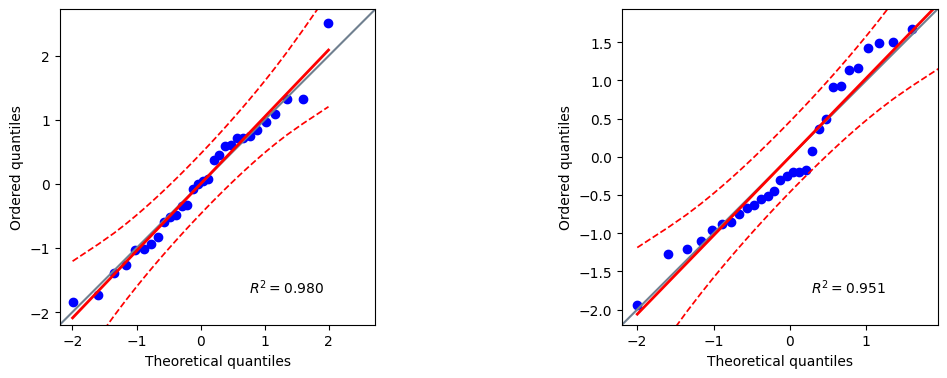

In [40]:
_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

pg.qqplot(x_normal, ax=axes[0])
pg.qqplot(x_not_normal, ax=axes[1]);

SciPy also provides similar plots (probability plots) with [probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html):

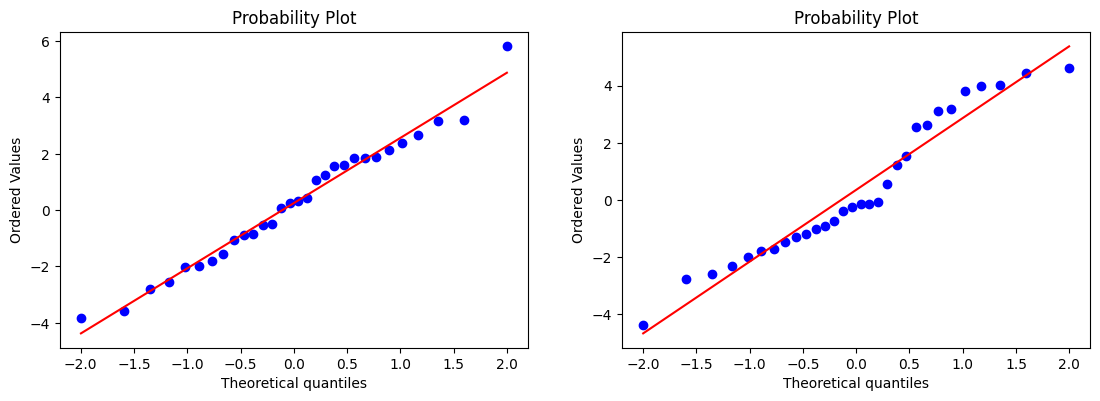

In [41]:
_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

stats.probplot(x_normal, plot=axes[0])
stats.probplot(x_not_normal, plot=axes[1]);

#### Normality tests

With Pingouin:

In [42]:
pg.normality(x_not_normal)#, method='jarque_bera')

,W,pval,normal
0,0.940223,0.092225,True


A major issue with tests of normality is they depend too much on the sample size. They are not powerful enough on small samples, and tend to see departures of normality everywhere in large samples.


Similar options can be found in Scipy:
* D'Agostino's test: [normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html), preferably for large samples ($n>20$),
    * Similar test for skewness only: [skewtest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html) ($n\ge8$),

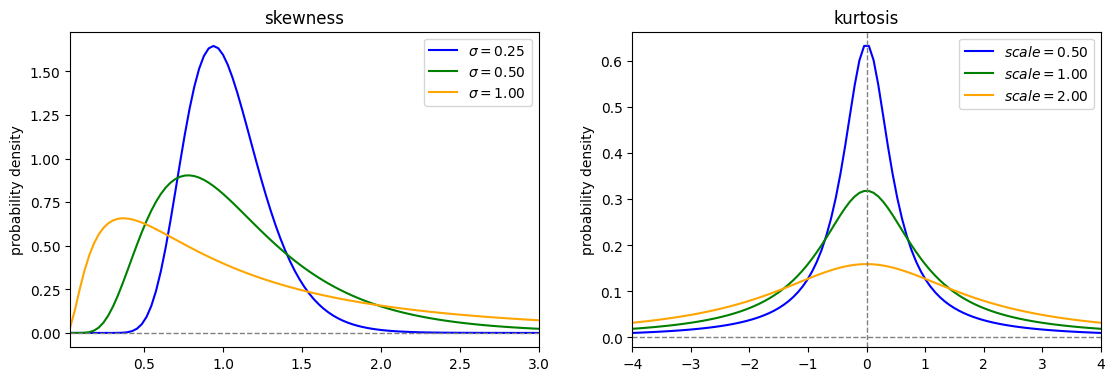

In [43]:
scipy_material.illustration_skewness_kurtosis()

* Shapiro-Wilk's test: [shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html),
* Generic goodness-of-fit tests: [kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) and [anderson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html).

### Equal variance (homoscedasticity)

#### Graphical approaches

Simple per-group box plots.

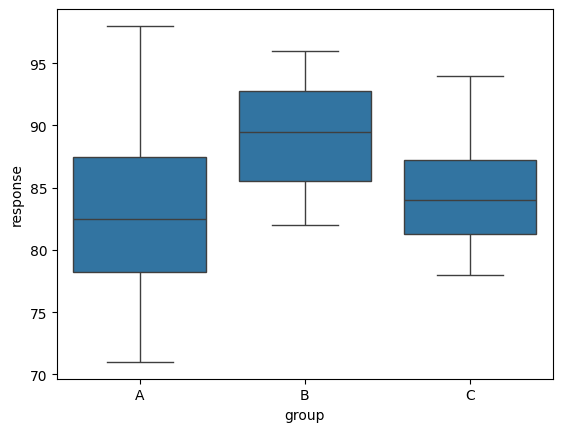

In [44]:
sns.boxplot(df, y='response', x='group');

#### Equality-of-variance tests

In [45]:
pg.homoscedasticity(df, dv='response', group='group')

,W,pval,equal_var
levene,2.080216,0.144465,True


In SciPy, we also find:
* Bartlett's test: [bartlett](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html), most basic and common test,
* Levene's test: [levene](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html), better for skewed or heavy-tailed distributions,
* ...and others: Fligner-Killeen's test ([fligner](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html)), Ansari-Bradley's test ([ansari](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ansari.html)), etc

Example:

In [46]:
stats.bartlett(A, B, C)

BartlettResult(statistic=3.3024375753550594, pvalue=0.19181598314035977)

In the above example, as there is not enough evidence to reject $H_0$ ($p>0.05$), we can proceed to perform a standard one-way ANOVA, for example with Pingouin's `anova`. Otherwise, we would use Pingouin's [`welch_anova`](https://pingouin-stats.org/generated/pingouin.welch_anova.html) or SciPy's [`alexandergovern`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alexandergovern.html).

## χ² tests

When the sum of the observations is known, *e.g.* observations are frequencies -- proportions that sum to $1$, we use a $\chi^2$ test instead of an ANOVA.

These tests are named after the $\chi^2$ distribution. Tests based on this distribution derive a one-sided *p*-value.

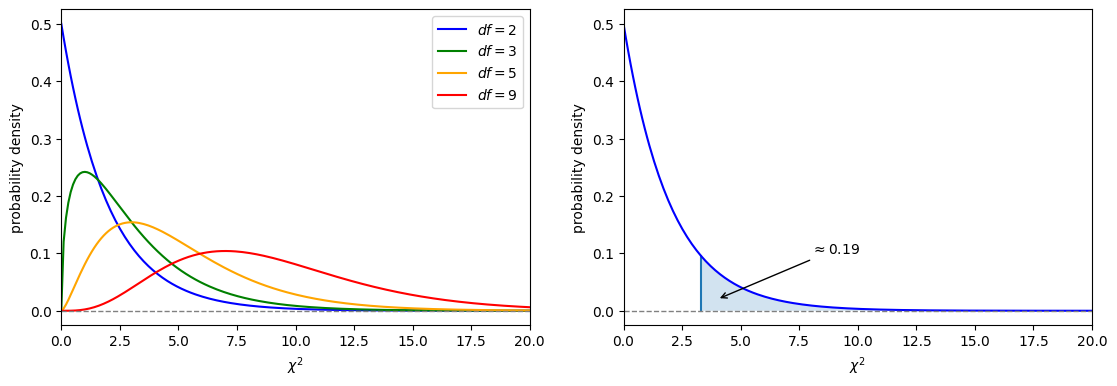

In [47]:
scipy_material.illustration_chi2()

We will use:
* SciPy's [`contingency.crosstab`](), [`chisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) and [`chi2_contingency`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html),
* Pingouin's [`chi2_independence`](https://pingouin-stats.org/build/html/generated/pingouin.chi2_independence.html#pingouin.chi2_independence).

Scipy's functions take counts as input data, while Pingouin's only function takes a dataframe and the column names of categorical variables.

If we have data in long format:

In [48]:
tips = pg.read_dataset('tips')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


We can summarize the crossed counts of the categorical variables in a contingency table, using SciPy's `contingency.crosstab`:

In [49]:
(row_labels, col_labels), counts = stats.contingency.crosstab(tips['sex'], tips['day'])
observed_counts = pd.DataFrame(counts, index=row_labels, columns=col_labels)
observed_counts

,Fri,Sat,Sun,Thur
Female,9,28,18,32
Male,10,59,58,30


### Homogeneity and independence

$H_0$: men and women give tips following a similar weekly pattern.

If we consider the proportion of each day in the total collected tips:

In [50]:
expected_props = observed_counts.sum(axis=0) / observed_counts.values.sum()

pd.DataFrame(dict(Altogether=expected_props)).T

,Fri,Sat,Sun,Thur
Altogether,0.077869,0.356557,0.311475,0.254098


$H_0$ can be expressed in terms of proportions as:

In [51]:
pd.DataFrame(dict(Female=expected_props, Male=expected_props)).T

,Fri,Sat,Sun,Thur
Female,0.077869,0.356557,0.311475,0.254098
Male,0.077869,0.356557,0.311475,0.254098


Or equivalently in terms of counts:

In [52]:
expected_counts = np.outer(observed_counts.sum(axis=1), expected_props)

pd.DataFrame(expected_counts, index=row_labels, columns=col_labels)

,Fri,Sat,Sun,Thur
Female,6.77459,31.020492,27.098361,22.106557
Male,12.22541,55.979508,48.901639,39.893443


These counts are not integers. They are theoretical counts. We can contrast them with the observed counts, and derive the following statistic:

$$
\chi^2 = \sum_{i=1}^{k}\sum_{j=1}^{l} \frac{(O_{ij} - E_{ij})^2}{E_{ij}} \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \sim \chi^2_{(k-1)(l-1)} \mbox{ } \textrm{under} \mbox{ } H_0
$$

where $O_{ij}$ are the observed counts and $E_{ij}$ the expected or theoretical counts.

In [53]:
j, k = expected_counts.shape
dof = (j - 1) * (k - 1)
chi2 = np.sum((observed_counts.values - expected_counts) ** 2 / expected_counts)
chi2

13.222001372406606

The $p$-value can calculated as follows:

In [54]:
stats.chi2(dof).sf(chi2)

0.004180302092822262

SciPy's $\chi^2$ test for homogeneity/independence is [chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html):

In [55]:
chi2, pvalue, dof, expected_props = stats.chi2_contingency(observed_counts)
(chi2, pvalue)

(13.22200137240661, 0.004180302092822257)

Due to the design of the test, it doesn't matter what factor whose effect is hypothesized to be null under $H_0$. We get the exact same result after transposing the contingency table:

In [56]:
chi2, pvalue, dof, expected_props_T = stats.chi2_contingency(observed_counts.T)
(chi2, pvalue)

(13.22200137240661, 0.004180302092822257)

As already mentioned, Pingouin's `chi2_independence` is suitable for data in long format:

In [57]:
expected_counts, observed_counts, test_results = pg.chi2_independence(tips, 'sex', 'day')
test_results

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,13.222001,3.0,0.004180,0.232784,0.876800
1,cressie-read,0.666667,13.186226,3.0,0.004251,0.232469,0.875841
2,log-likelihood,0.000000,13.194401,3.0,0.004235,0.232541,0.876061
3,freeman-tukey,-0.500000,13.270507,3.0,0.004087,0.233211,0.878089
4,mod-log-likelihood,-1.000000,13.407679,3.0,0.003833,0.234413,0.881673
5,neyman,-2.000000,13.873557,3.0,0.003082,0.238451,0.893170


### Goodness-of-fit

Instead of inferring theoretical counts from the observed counts, we may want to test *vs* predefined (theoretical) counts. This is essentially the same test.

A random example: [Color proportion of M&Ms [Coursera]](https://www.coursera.org/learn/stanford-statistics/lecture/rAwbR/the-color-proportions-of-m-ms):
| blue | orange | green | yellow | red | brown |
| :-:  | :-:    | :-:   | :-:    | :-: | :-:   |
| 24%  | 20%    | 16%   | 14%    | 13% | 13%   |

In [58]:
expected_props  = np.array([ .24, .2, .16, .14, .13, .13 ])
observed_counts = np.array([ 85, 79, 56, 64, 58, 68 ])
np.sum(observed_counts)

410

In [59]:
expected_counts = expected_props * np.sum(observed_counts)
expected_counts

array([98.4, 82. , 65.6, 57.4, 53.3, 53.3])

|          | blue | orange | green | yellow | red  | brown |
| --:      | :-:  | :-:    | :-:   | :-:    | :-:  | :-:   |
| Expected | 98.4 | 82     | 65.6  | 57.4   | 53.3 | 53.3  |
| Observed | 85   | 79     | 56    | 64     | 58   | 58    |

The statistic is again:

$$
\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i} \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \sim \chi^2_{k-1} \mbox{ } \textrm{under} \mbox{ } H_0
$$

In [60]:
k = len(expected_counts)
chi2 = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
chi2

8.566983829178941

In [61]:
pvalue = stats.chi2(k-1).sf(chi2)
pvalue

0.1276329790529603

SciPy's implementation of the test is [chisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html):

In [62]:
stats.chisquare(observed_counts, expected_counts)

Power_divergenceResult(statistic=8.566983829178941, pvalue=0.1276329790529603)

Pingouin's `chi2_independence` is not suitable for performing this test.

### Two-sample goodness-of-fit

The $\chi^2$ test can also be used for comparing the distributions of a continuous variable for two samples (two groups) in a more general way than a $t$-test for independent samples.

The procedure consists in binning the continuous variable so that the problem can be formulated as a homogeneity test, with bins as the levels of one factor, and the grouping criterion as another factor.

As a consequence, we will use the same functions as before.

A similar test is the two-sample Kolmogorov-Smirnov test implemented in SciPy as [ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html). This test does not require binning.